<a href="https://colab.research.google.com/github/OnePassio/CE888/blob/master/Assignment2/1_Covariate_Shift_Problem_Print_Correlation_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Library

In [0]:
# Initial Library
# data analysis
import pandas as pd
import numpy as np
import random as rand

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warning message
import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# 1.Load Data from Kaggle
Source Data: https://www.kaggle.com/c/microsoft-malware-prediction/

!kaggle competitions download -c microsoft-malware-prediction

In [2]:
# load data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "thomastran89" # username from the json file
os.environ['KAGGLE_KEY'] = "be79bdf7a2010c5b7a9aeac8ed316490" # key from the json file
!kaggle competitions download -c microsoft-malware-prediction # api copied from kaggle
# Unzip the data
!sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
# Check files after unzip
!ls

 97% 654M/672M [00:03<00:00, 171MB/s]
100% 672M/672M [00:03<00:00, 197MB/s]
 92% 123M/134M [00:01<00:00, 76.7MB/s]
100% 134M/134M [00:01<00:00, 81.9MB/s]
 99% 760M/768M [00:04<00:00, 195MB/s]
100% 768M/768M [00:04<00:00, 180MB/s]
/bin/bash: sample_submission.csv.zip: command not found
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
sample_data		   test.csv	 train.csv
sample_submission.csv.zip  test.csv.zip  train.csv.zip


In [174]:
# load partial data for test first
sample_size= 1000000 # data too heavy and can not load by Google Colab -> Test on 1M first rows

# Load Train Data
df_train_org = pd.read_csv("train.csv",skiprows=0, nrows=sample_size)

# Load Test Data
df_test_org= pd.read_csv("test.csv",skiprows=0, nrows=sample_size)

df_train_org.head()
#df_test.head()


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,...,HDD,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,...,HDD,102385.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4909.0,317701.0,4.0,5.0,...,SSD,113907.0,0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,...,UNKNOWN,227116.0,0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,355.0,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417e

# 2. Preprocessing Data

## 2.1. Remove some unused features to build model of dataset
Remove unique ID column


In [175]:
#cache
df_train_id=df_test_org['MachineIdentifier'].copy()
df_test_id=df_test_org['MachineIdentifier'].copy()
# remove id
df_train=df_train_org.drop('MachineIdentifier',axis=1)
df_test=df_test_org.drop('MachineIdentifier',axis=1)

df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,58552.0,18.0,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,807.0,8554.0,1,NaN,0.0,0,0,0.0,0.0,7.0
1,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,68,71395.0,NaN,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,554.0,33105.0,1,NaN,0.0,0,0,0.0,1.0,12.0
2,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,NaN,49480.0,2.0,1.0,1,201,66202.0,NaN,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,NaN,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,NaN,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63396.0,1,NaN,0.0,0,0,0.0,1.0,11.0
3,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,NaN,42160.0,2.0,1.0,1,29,120917.0,NaN,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,26.0,119,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,628.0,26320.0,1,0.0,0.0,0,0,0.0,0.0,10.0
4,win8defender,1.1.15400.4,4

### 2.2. Fill NaN missing value

In [176]:
## missing values on train.csv
for i in df_train.columns:
    if df_train[i].dtype == 'object':
      df_train[i] = df_train[i].fillna(df_train[i].mode().iloc[0])
    if (df_train[i].dtype == 'int' or df_train[i].dtype == 'float'):
      df_train[i] = df_train[i].fillna(np.mean(df_train[i]))

## missing values on test.csv
for i in df_test.columns:
    if df_test[i].dtype == 'object':
      df_test[i] = df_test[i].fillna(df_test[i].mode().iloc[0])
    if (df_test[i].dtype == 'int' or df_test[i].dtype == 'float'):
      df_test[i] = df_test[i].fillna(np.mean(df_test[i]))
      
df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,on,0.003095,108.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,0.0,0.0,Retail,0.000305,807.0,8554.0,1,0.0,0.0,0,0,0.0,0.0,7.0
1,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,68,71395.0,24.950211,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,on,0.003095,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,lion,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.000305,554.0,33105.0,1,0.0,0.0,0,0,0.0,1.0,12.0
2,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,1603.500972,49480.0,2.0,1.0,1,201,66202.0,24.950211,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,on,0.003095,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,lion,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,0.0,0.0,Retail,0.000305,556.0,63396.0,1,0.0,0.0,0,0,0.0,1.0,11.0
3,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,1603.500972,42160.0,2.0,1.0,1,29,120917.0,24.950211,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,on,0.003095,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,26.0,119,Notify,0,IS_GENUI

## 2.3. label encoding

In [177]:
# encoder, alternative is convert to dummies
number = LabelEncoder()
for i in df_train.columns:
    if (df_train[i].dtype == 'object'):
      df_train[i] = number.fit_transform(df_train[i].astype('str'))
      df_train[i] = df_train[i].astype('object')

for i in df_test.columns:
    if (df_test[i].dtype == 'object'):
      df_test[i] = number.fit_transform(df_test[i].astype('str'))
      df_test[i] = df_test[i].astype('object')

df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,3,55,59,7690,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,0,1,0,15063,768,2,225,4,1.0,0,1,0.003095,108.0,8,1.0,1.0,7,1,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,1,123179.0,0,8192.0,22,15.5,1920.0,1080.0,3,25,8.0,190,0,1,15063,1387,1,1,5,37.0,158,0,0,1,0,0.0,0.0,3,0.000305,807.0,8554.0,1,0.0,0.0,0,0,0.0,0.0,7.0
1,3,54,54,7434,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,68,71395.0,24.950211,276.0,74,0,1,0,16299,768,3,231,4,1.0,0,1,0.003095,117.0,8,1.0,1.0,7,1,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,0,1882352.0,0,8192.0,22,15.5,1366.0,768.0,3,25,0.0,239,0,3,16299,611,1,1,6,7.0,30,0,0,1,2,0.0,0.0,3,0.000305,554.0,33105.0,1,0.0,0.0,0,0,0.0,1.0,12.0
2,3,52,54,6930,0,7.0,0,1603.500972,49480.0,2.0,1.0,1,201,66202.0,24.950211,267.0,251,0,1,0,14393,768,1,172,4,1.0,0,1,0.003095,98.0,8,1.0,1.0,7,1,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,1,28678.0,0,4096.0,22,13.9,1280.0,720.0,3,25,0.0,130,0,0,14393,2189,4,4,3,35.0,148,5,0,1,0,0.0,0.0,3,0.000305,556.0,63396.0,1,0.0,0.0,0,0,0.0,1.0,11.0
3,3,55,59,7730,0,7.0,0,1603.500972,42160.0,2.0,1.0,1,29,120917.0,24.950211,35.0,171,0,1,0,16299,768,3,227,4,1.0,0,1,0.003095,117.0,8,1.0,1.0,7,1,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,0,439345.0,0,4096.0,22,14.0,1366.0,768.0,3,22,0.0,229,0,2,16299,371,4,4,8,26.0,119,3,0,1,0,0.0,0.0,3,0.000000,628.0,26320.0,1,0.0,0.0,0,0,0.0,0.0,10.0
4,3,54,54,7418,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,171,124736.0,18.000000,211.0,182,0,1,0,16299,768,3,227,4,1.0,0,1,0.003095,117.0,8,1.0,1.0,7,1,585.0,189538.0,4.0,5.0,3394.0,...,476940.0,0,461506.0,1,2048.0,22,15.5,1366.0,768.0,3,25,0.0,229,0,2,16299,371,4,4,7,29.0,125,5,0,1,2,0.0,0.0,3,0.000305,556.0,63269.0,1,0.0,0.0,0,0,0.0,1.0,3.0


## 2.4. creating a new feature origin


In [178]:
df_train['origin'] = 0
df_test['origin'] = 1
df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,origin
0,3,55,59,7690,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,0,1,0,15063,768,2,225,4,1.0,0,1,0.003095,108.0,8,1.0,1.0,7,1,2689.0,30661.0,4.0,5.0,3063.0,...,1,123179.0,0,8192.0,22,15.5,1920.0,1080.0,3,25,8.0,190,0,1,15063,1387,1,1,5,37.0,158,0,0,1,0,0.0,0.0,3,0.000305,807.0,8554.0,1,0.0,0.0,0,0,0.0,0.0,7.0,1
1,3,54,54,7434,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,68,71395.0,24.950211,276.0,74,0,1,0,16299,768,3,231,4,1.0,0,1,0.003095,117.0,8,1.0,1.0,7,1,2206.0,242491.0,4.0,5.0,3410.0,...,0,1882352.0,0,8192.0,22,15.5,1366.0,768.0,3,25,0.0,239,0,3,16299,611,1,1,6,7.0,30,0,0,1,2,0.0,0.0,3,0.000305,554.0,33105.0,1,0.0,0.0,0,0,0.0,1.0,12.0,1
2,3,52,54,6930,0,7.0,0,1603.500972,49480.0,2.0,1.0,1,201,66202.0,24.950211,267.0,251,0,1,0,14393,768,1,172,4,1.0,0,1,0.003095,98.0,8,1.0,1.0,7,1,585.0,189533.0,2.0,5.0,2097.0,...,1,28678.0,0,4096.0,22,13.9,1280.0,720.0,3,25,0.0,130,0,0,14393,2189,4,4,3,35.0,148,5,0,1,0,0.0,0.0,3,0.000305,556.0,63396.0,1,0.0,0.0,0,0,0.0,1.0,11.0,1
3,3,55,59,7730,0,7.0,0,1603.500972,42160.0,2.0,1.0,1,29,120917.0,24.950211,35.0,171,0,1,0,16299,768,3,227,4,1.0,0,1,0.003095,117.0,8,1.0,1.0,7,1,2668.0,171228.0,2.0,5.0,1985.0,...,0,439345.0,0,4096.0,22,14.0,1366.0,768.0,3,22,0.0,229,0,2,16299,371,4,4,8,26.0,119,3,0,1,0,0.0,0.0,3,0.000000,628.0,26320.0,1,0.0,0.0,0,0,0.0,0.0,10.0,1
4,3,54,54,7418,0,7.0,0,1603.500972,53447.0,1.0,1.0,1,171,124736.0,18.000000,211.0,182,0,1,0,16299,768,3,227,4,1.0,0,1,0.003095,117.0,8,1.0,1.0,7,1,585.0,189538.0,4.0,5.0,3394.0,...,0,461506.0,1,2048.0,22,15.5,1366.0,768.0,3,25,0.0,229,0,2,16299,371,4,4,7,29.0,125,5,0,1,2,0.0,0.0,3,0.000305,556.0,63269.0,1,0.0,0.0,0,0,0.0,1.0,3.0,1


## 2.5. Show correlation matrix 


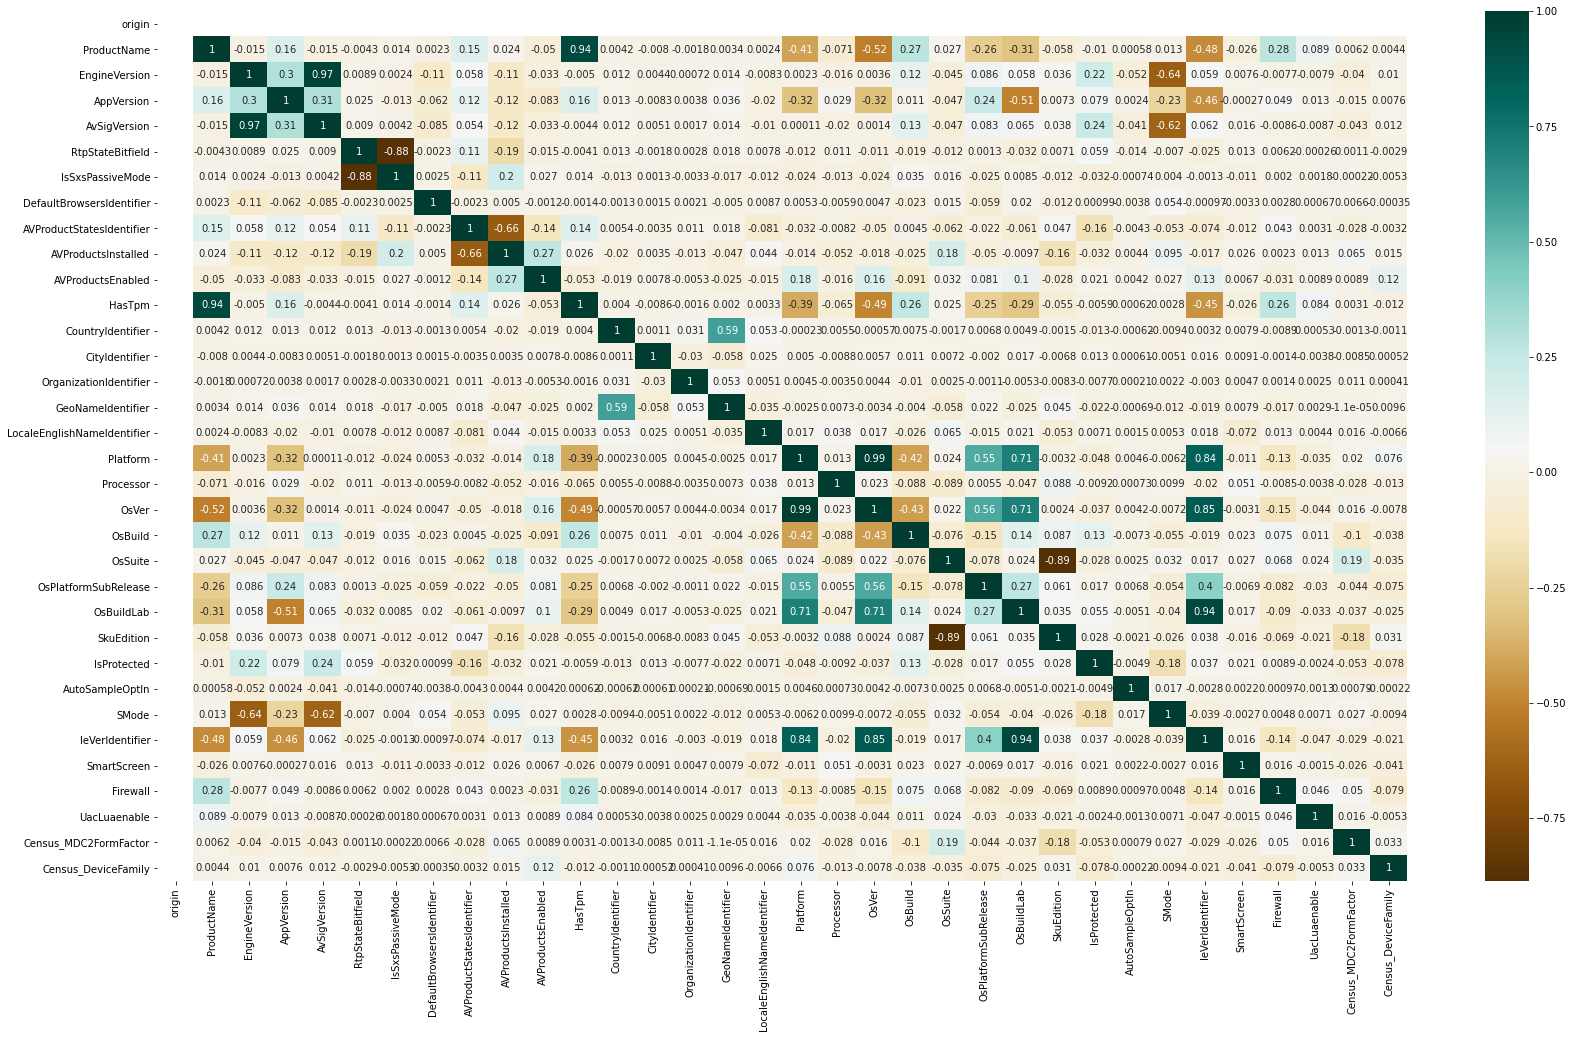

In [179]:
#correlation matrix
correlation = df_train.loc[:, ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion',
       'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'HasTpm', 'CountryIdentifier', 'CityIdentifier',
       'OrganizationIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer','OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'SMode',
       'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily']]
correlation = correlation.agg(LabelEncoder().fit_transform)
correlation['origin'] = df_train['origin'] 
correlation = correlation.set_index('origin').reset_index()

plt.figure(figsize = (28,16))
sns.heatmap(correlation.corr(), cmap ='BrBG', annot = True)
plt.title ='Variables Correlated with Origin'
plt.show()

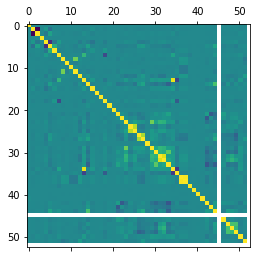

In [184]:
import matplotlib.pyplot as plt
plt.title="Train"
plt.matshow(df_train.drop('HasDetections',axis=1).corr())
plt.show()

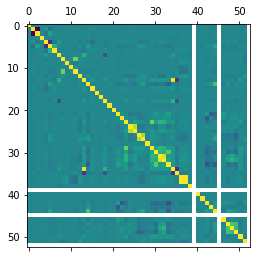

In [185]:
plt.title="Test"
plt.matshow(df_test.corr())
plt.show()